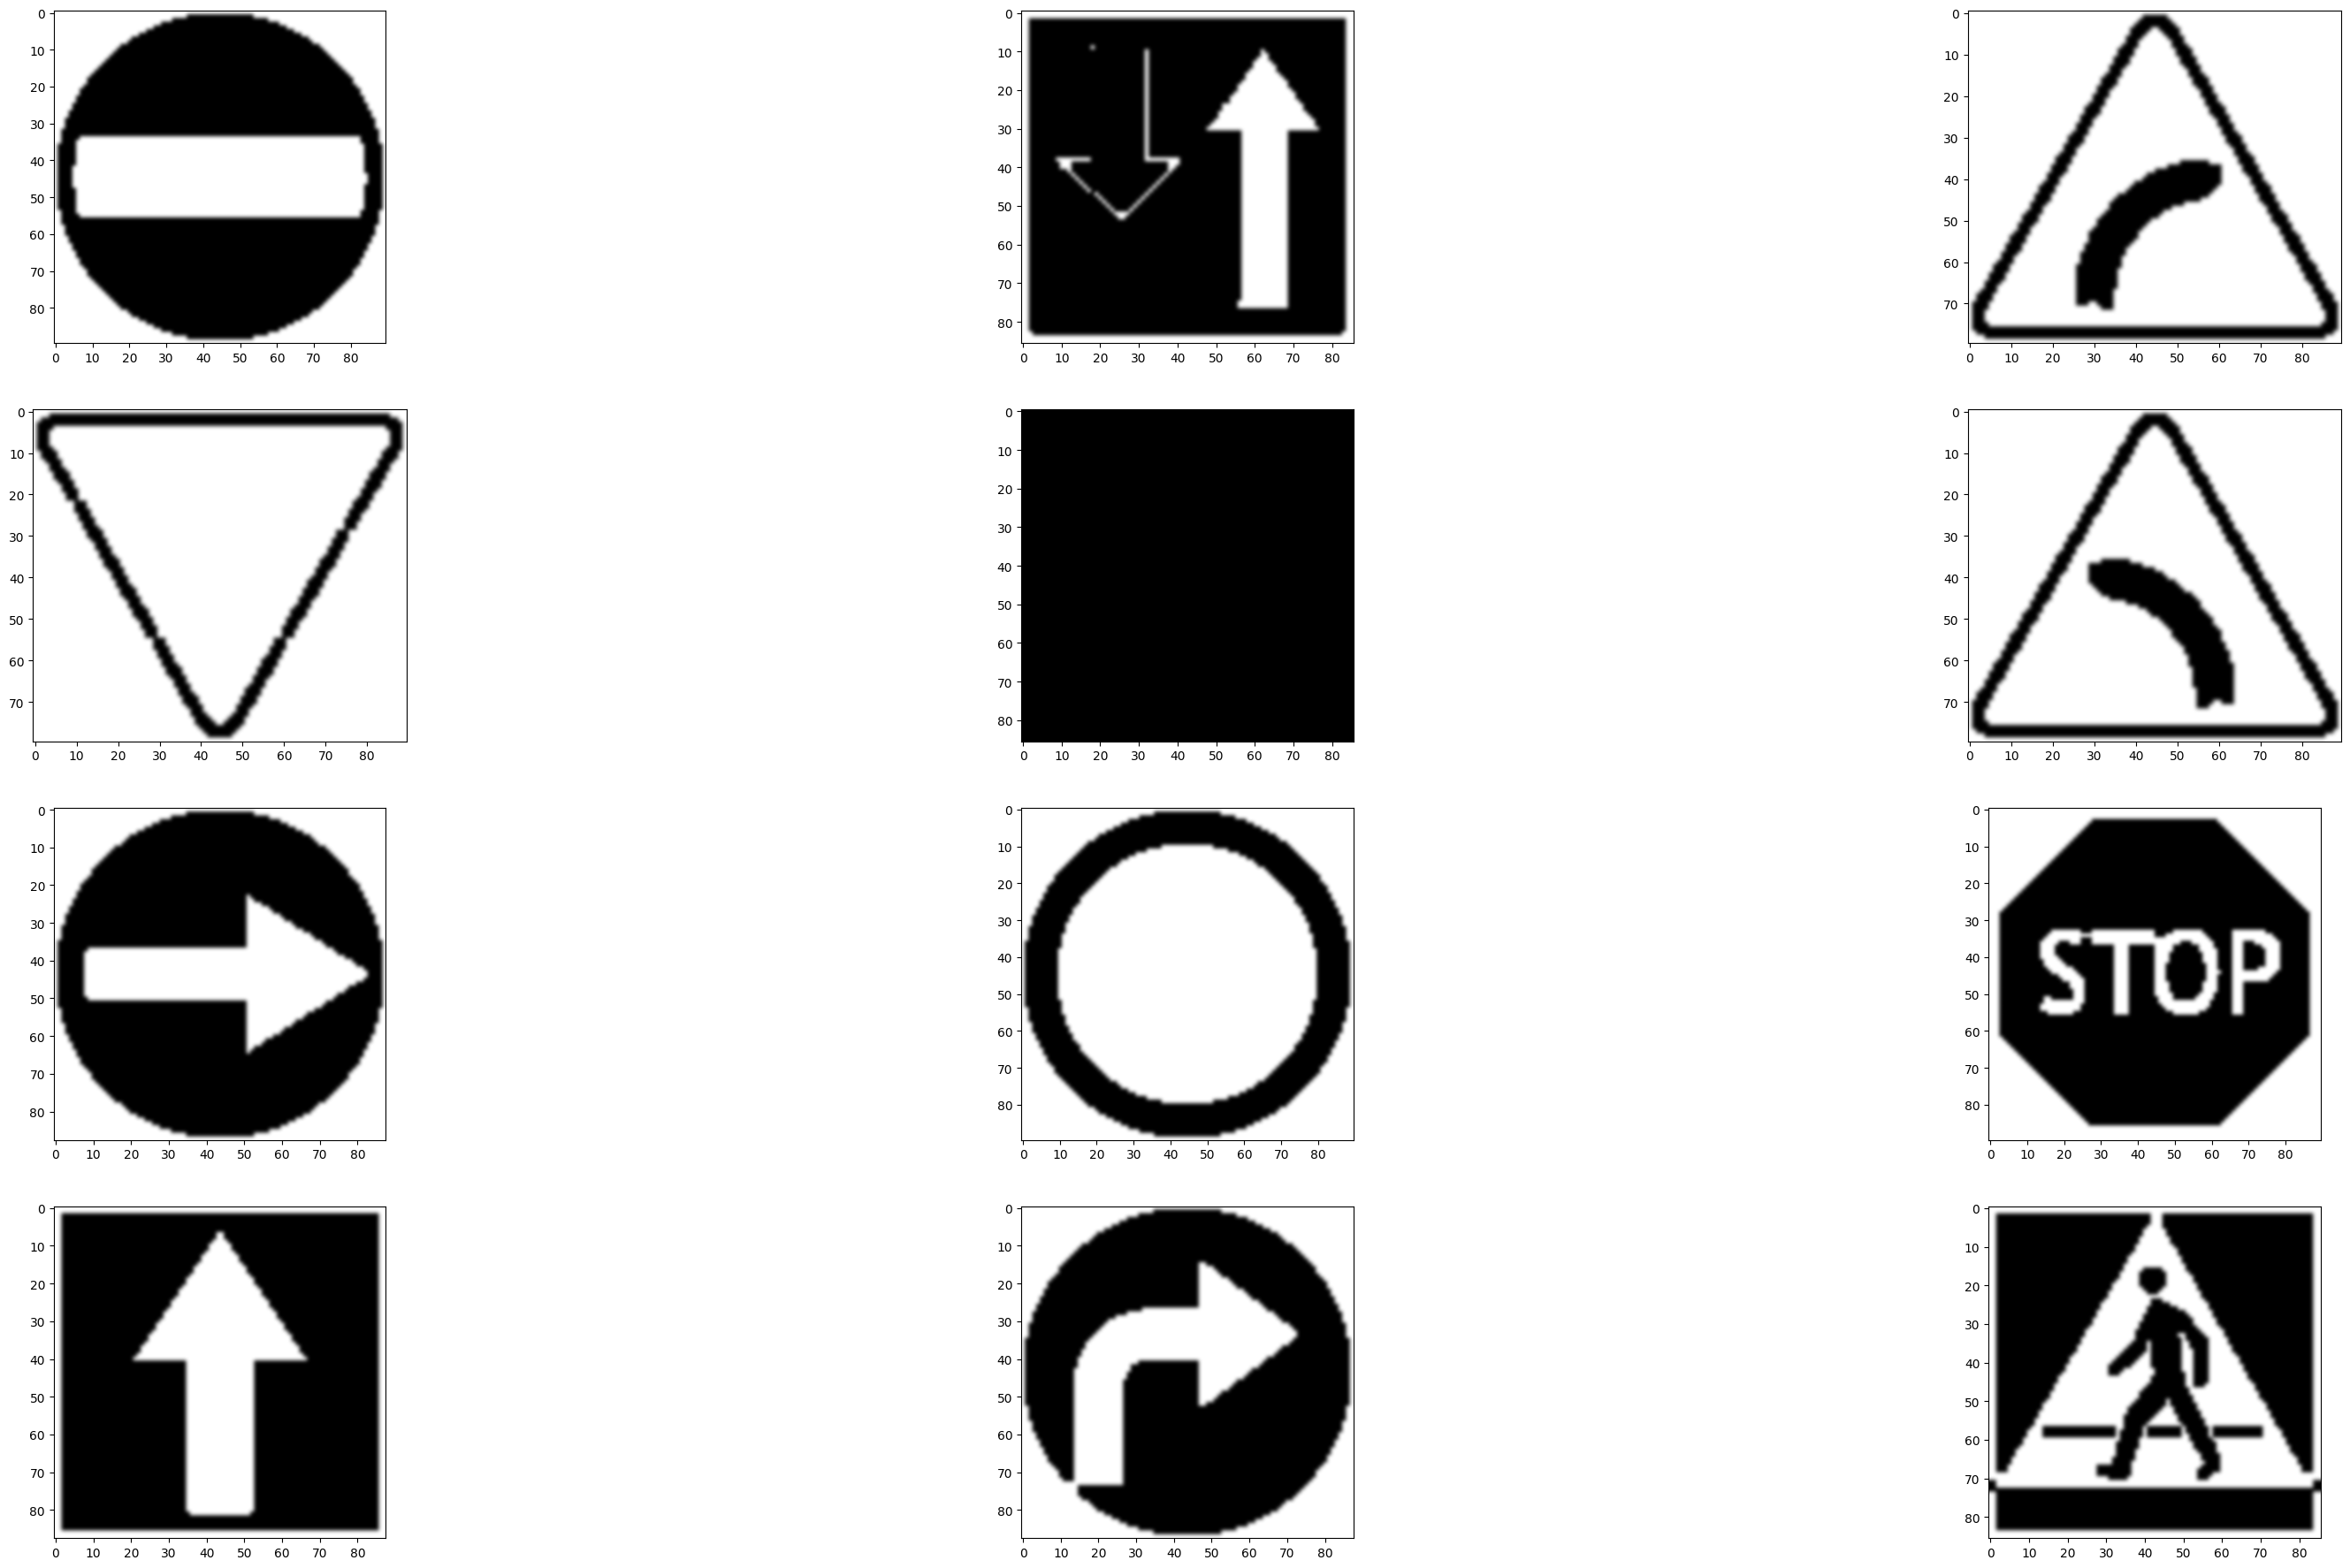

In [14]:
import cv2
import numpy as np
import glob
from numpy import uint8
from scipy.stats import circmean, circstd
from matplotlib import pyplot as plt

extensions = ("*.png","*.jpg","*.jpeg",)
glob_list = []
for extension in extensions:
    glob_list.extend(glob.glob("znaki/"+extension))
          
image_list = []
image_grey_list = []
image_contour_list = []
image_binary_list = []
image_hsv_list = []
col = 1

for filename in glob_list:
    
    im = cv2.imread(filename)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    image_list.append(im)
    
    hsv = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)
    
    # mask = cv2.inRange(hsv, (100, 178, 0), (140, 255, 255))
    mask = cv2.inRange(hsv, (20, 178, 0), (60, 255, 255)) + cv2.inRange(hsv, (160, 178, 0), (179, 255, 255)) + cv2.inRange(hsv, (0, 178, 0), (20, 255, 255))
    imask = mask>0
    temp = np.zeros_like(im, np.uint8)
    temp[imask] = im[imask]
    image_hsv_list.append(temp)
    
    gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    # gray = cv2.GaussianBlur(gray, (3,3), 3)
    # kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    kernel = np.array([[-0.5,-0.5,-0.5], [-0.5,5,-0.5], [-0.5,-0.5,-0.5]])
    gray = cv2.filter2D(gray, -1, kernel)
    image_grey_list.append(gray)
    
    # ret, binary = cv2.threshold(gray, 127,255, cv2.THRESH_BINARY_INV)
    # binary = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    ret, binary = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    # border = 50
    # binary = cv2.copyMakeBorder(binary, border, border, border, border, cv2.BORDER_CONSTANT, value=0)
    
    kernel = np.ones((3, 3), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    
    
    image_binary_list.append(binary)
    
    contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    con = cv2.drawContours(im, contours, -1, (0,255,0), 2)
    image_contour_list.append(con)

def printSigns(image_list, is_grey):
    f = plt.figure()
    f.set_figwidth(40)
    f.set_figheight(40)
    
    col_number = 3
    row_number = 7
    num = 1
    
    for img in image_list:
        plt.subplot(row_number,col_number,num)
        if is_grey:
            plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
        else:
            plt.imshow(img)
        num += 1
        
# printSigns(image_hsv_list, False)
# printSigns(image_list, False)
printSigns(image_binary_list, True)
# printSigns(image_grey_list, True)
# printSigns(image_contour_list, False)

In [15]:
import cv2
import numpy as np
from numpy import uint8
from scipy.stats import circmean, circstd
from matplotlib import pyplot as plt


BLACK_THRESHOLD_VALUE = 76
WHITE_THRESHOLD_VALUE_MIN = 140
WHITE_THRESHOLD_SATURATION_MAX = 30

COLORFUL_PIXELS_REQUIRED = 1000

HUE_MARGIN = 10
SATURATION_MARGIN_MIN = 50
VALUE_MARGIN_MIN = 50

HUE_MAX_THRESHOLD = 179

In [16]:

def readImageAsRGB(filename):
    BGR_image = cv2.imread(filename)
    RGB_image = cv2.cvtColor(BGR_image, cv2.COLOR_BGR2RGB)
    return RGB_image


def readImageAsHSV(filename):
    BGR_image = cv2.imread(filename)
    HSV_image = cv2.cvtColor(BGR_image, cv2.COLOR_BGR2HSV)
    return HSV_image

def getParametersFromImage(HSV_image):
    image_size = np.shape(HSV_image)[0]
    FILL_RATIO = 0.5
    return image_size

def getMeanHSV(HSV_list):
    hue_list = []
    saturation_sum = 0
    value_sum = 0
    for hsv in HSV_list:
        hue_list.append(hsv[0])
        saturation_sum += hsv[1]
        value_sum += hsv[2]
    hue_mean = circmean(hue_list, high=HUE_MAX_THRESHOLD+1)
    saturation_mean = saturation_sum / len(HSV_list)
    value_mean = value_sum / len(HSV_list)
    return (hue_mean, saturation_mean, value_mean)

def getStdHSV(HSV_list):
    hue_list = []
    saturation_list = []
    value_list = []
    for hsv in HSV_list:
        hue_list.append(hsv[0])
        saturation_list.append(hsv[1])
        value_list.append(hsv[2])
    hue_std = circstd(hue_list, high=HUE_MAX_THRESHOLD+1)
    saturation_std = np.std(saturation_list)
    value_std = np.std(value_list)
    return (hue_std, saturation_std, value_std)

In [17]:
def findMainColor(HSV_image):
    image_size = getParametersFromImage(HSV_image)
    middle_px = image_size // 2
    # what about image height?
    counter = 0
    distance = 0
    hsv_list = []
    # collect colorful(non-black and non-white) pixels starting from center
    # procedure iterates through wider and wider squares until a certain amount is collected
    while (counter < COLORFUL_PIXELS_REQUIRED):
        for i in range(middle_px - distance, middle_px + distance + 1):
            for j in range(middle_px - distance, middle_px + distance + 1):
                if isEdge(i, j, middle_px, distance) and isColorful(HSV_image[i][j]):
                    counter += 1
                    hsv_list.append(HSV_image[i][j])
        distance += 1
    meanHSV = getMeanHSV(hsv_list)
    return meanHSV[0], meanHSV[1], meanHSV[2]


def isEdge(x, y, middle, distance):
    return x == middle - distance or y == middle - distance or x == middle + distance or y == middle + distance


def isColorful(HSV_value):
    return not isBlack(HSV_value) and not isWhite(HSV_value)


def isBlack(HSV_value):
    return HSV_value[2] < BLACK_THRESHOLD_VALUE


def isWhite(HSV_value):
    return HSV_value[2] > WHITE_THRESHOLD_VALUE_MIN and HSV_value[1] < WHITE_THRESHOLD_SATURATION_MAX

In [18]:
def makeMask(HSV_image, HSV_mean):

    lower_hue = HSV_mean[0] - HUE_MARGIN
    if lower_hue < 0:
        lower_hue += HUE_MAX_THRESHOLD
    if lower_hue > HUE_MAX_THRESHOLD:
        lower_hue -= HUE_MAX_THRESHOLD

    upper_hue = HSV_mean[0] + HUE_MARGIN
    if upper_hue < 0:
        upper_hue += HUE_MAX_THRESHOLD
    if upper_hue > HUE_MAX_THRESHOLD:
        upper_hue -= HUE_MAX_THRESHOLD

    lowerBound = (
        lower_hue, HSV_mean[1] - SATURATION_MARGIN_MIN, HSV_mean[2] - VALUE_MARGIN_MIN)
    upperBound = (upper_hue, 255, 255)

    if lowerBound[0] > upperBound[0]:
        mask1 = cv2.inRange(HSV_image, lowerb=(
            0, lowerBound[1], lowerBound[2]), upperb=upperBound)
        mask2 = cv2.inRange(HSV_image, lowerb=lowerBound, upperb=(
            HUE_MAX_THRESHOLD, upperBound[1], upperBound[2]))
        mask = mask1 | mask2
    else:
        mask = cv2.inRange(HSV_image, lowerb=lowerBound, upperb=upperBound)

    temp = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours = temp[-2]
    cv2.drawContours(mask, contours, contourIdx=-1,
                     color=(255, 255, 255), thickness=-1)

    return mask


def makeContourMask(inside_mask, contour_width):

    mask = inside_mask

    mask_not_bin = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    mask_contour = np.zeros((np.shape(mask)[0], np.shape(mask)[1]))
    contours, hierarchy = cv2.findContours(
        mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(mask_contour, contours, -1,
                     (255, 255, 255), contour_width*2)
    mask_contour = np.array(mask_contour, dtype=uint8)

    return mask_contour - cv2.bitwise_and(mask_contour, mask)


def applyMask(img, mask):
    return cv2.bitwise_and(img, img, mask=mask)

def getHSVimageValuesFromMask(HSV_image, BIN_mask):

    # if np.shape(HSV_image) is not np.shape(BIN_mask):
    #     raise BaseException("Coś jest nie halo!")

    HSV_list = []
    for i in range(np.shape(HSV_image)[0]):
        for j in range(np.shape(HSV_image)[1]):
            if BIN_mask[i][j]:
                HSV_list.append(HSV_image[i][j])

    return HSV_list

def getMaskWithBorder(HSV_image, BIN_mask):
    contour_px_iterator = 1
    hue_std = 0
    saturation_std = 0
    value_std = 0
    HUE_STD_MAX = 10
    SATURATION_STD_MAX = 45
    VALUE_STD_MAX = 45
    mask = BIN_mask
    hue_mean, saturation_mean, value_mean = findMainColor(HSV_image)
    HSV_mean = (hue_mean, saturation_mean, value_mean)
    while (hue_std < HUE_STD_MAX and saturation_std < SATURATION_STD_MAX and value_std < VALUE_STD_MAX):
        mask_border = makeContourMask(mask, contour_px_iterator)
        mask_border_hsv_list = getHSVimageValuesFromMask(HSV_image, mask_border)
        hue_std = getStdHSV(mask_border_hsv_list)[0]
        saturation_std = getStdHSV(mask_border_hsv_list)[1]
        value_std = getStdHSV(mask_border_hsv_list)[2]
        if (hue_std < HUE_STD_MAX and saturation_std < SATURATION_STD_MAX and value_std < VALUE_STD_MAX):
            mask += mask_border
    return mask


In [19]:
def getCroppedSign(filename):
    hue_mean, saturation_mean, value_mean = findMainColor(
        readImageAsHSV(filename))
    HSV_mean = (hue_mean, saturation_mean, value_mean)
    mask = makeMask(readImageAsHSV(filename), HSV_mean)
    croppedSign = applyMask(readImageAsRGB(filename), mask)
    return croppedSign

In [20]:
def showAllMasks():
    extensions = ("*.png", "*.jpg", "*.jpeg",)
    glob_list = []
    for extension in extensions:
        glob_list.extend(glob.glob("znaki/"+extension))

    mask_list = []

    for filename in glob_list:

        hue_mean, saturation_mean, value_mean = findMainColor(
            readImageAsHSV(filename))
        HSV_mean = (hue_mean, saturation_mean, value_mean)
        mask = makeMask(readImageAsHSV(filename), HSV_mean)
        mask_list.append(mask)

    printSigns(mask_list, True)


def showSingleMask(filename):
    hue_mean, saturation_mean, value_mean = findMainColor(
        readImageAsHSV(filename))
    HSV_mean = (hue_mean, saturation_mean, value_mean)
    mask = makeMask(readImageAsHSV(filename), HSV_mean)
    plt.imshow(mask, cmap='gray')


def showCroppedImages():
    extensions = ("*.png", "*.jpg", "*.jpeg",)
    glob_list = []
    for extension in extensions:
        glob_list.extend(glob.glob("znaki/"+extension))

    image_list = []

    for filename in glob_list:

        hue_mean, saturation_mean, value_mean = findMainColor(
            readImageAsHSV(filename))
        HSV_mean = (hue_mean, saturation_mean, value_mean)
        mask = makeMask(readImageAsHSV(filename), HSV_mean)
        image_list.append(applyMask(readImageAsRGB(filename), mask))
        # image_list.append(mask)

    printSigns(image_list, False)
    
def showFinalCroppedImages():
    extensions = ("*.png", "*.jpg", "*.jpeg",)
    glob_list = []
    for extension in extensions:
        glob_list.extend(glob.glob("znaki/"+extension))

    image_list = []

    for filename in glob_list:

        hue_mean, saturation_mean, value_mean = findMainColor(
            readImageAsHSV(filename))
        HSV_mean = (hue_mean, saturation_mean, value_mean)
        mask = getMaskWithBorder(readImageAsHSV(filename), makeMask(readImageAsHSV(filename),HSV_mean))
        image_list.append(applyMask(readImageAsRGB(filename), mask))
        # image_list.append(mask)

    printSigns(image_list, False)


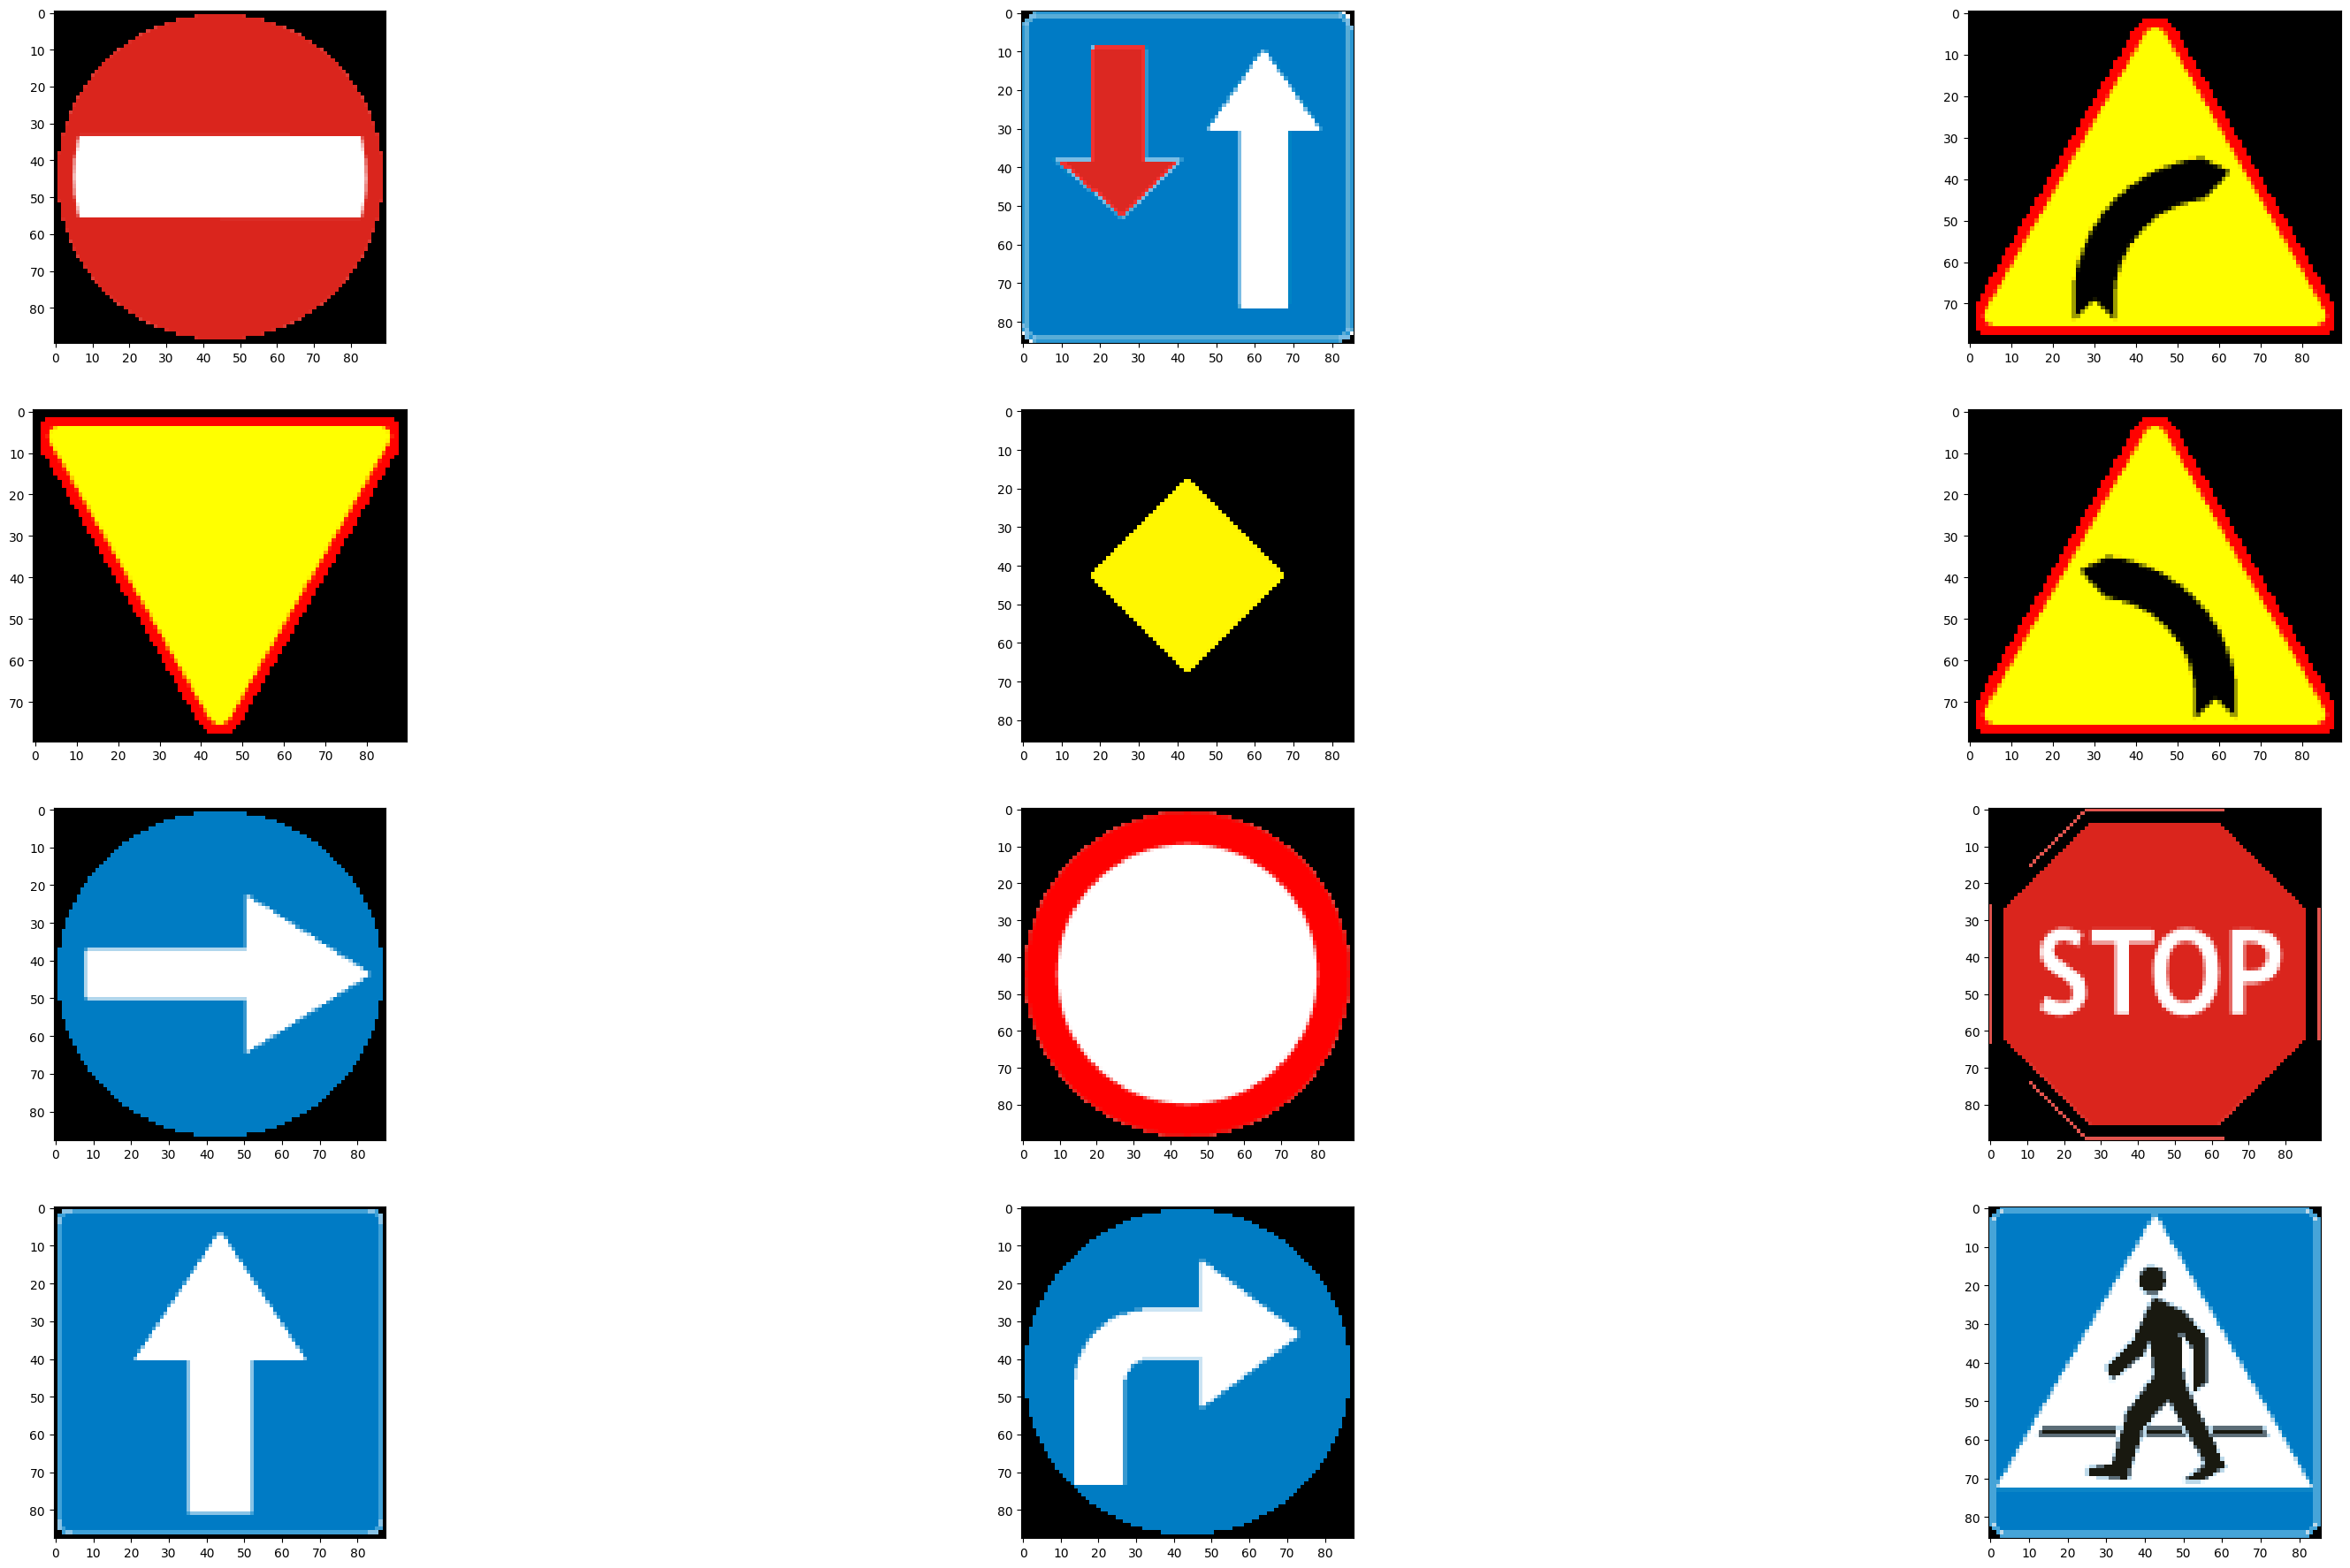

In [22]:

# showCroppedImages()
filename = "znaki/A-7_4.jpeg"
# hue_mean, saturation_mean, value_mean = findMainColor(readImageAsHSV(filename))
# HSV_mean = (hue_mean, saturation_mean, value_mean)
# img = makeContourMask(readImageAsHSV(filename), HSV_mean, 30)
# plt.imshow(img, cmap="gray")

# hsv_border_list = getHSVimageValuesFromMask(readImageAsHSV(filename), img)

# print(getMeanHSV(hsv_border_list))
# print(getStdHSV(hsv_border_list))

# image = applyMask(readImageAsRGB(filename), img)
# plt.imshow(image)
# hue_mean, saturation_mean, value_mean = findMainColor(readImageAsHSV(filename))
# HSV_mean = (hue_mean, saturation_mean, value_mean)
# mask = getMaskWithBorder(readImageAsHSV(filename), makeMask(readImageAsHSV(filename),HSV_mean))
# plt.imshow(applyMask(readImageAsRGB(filename), mask))

showFinalCroppedImages()
